## TA-lib (Análise Técnica): Instalação e uso

In [12]:
# !pip install TA-Lib ==>> Dá erro, porque precisa de ter TA-lib já instalada

# Como instalar:
# Baixar o arquivo aqui: https://www.lfd.uci.edu/~gohlke/pythonlibs/#ta-lib
# O meu python é 3.8.5, conforme celula abaixo, então baixei o arquivo 
# TA_Lib‑0.4.19‑cp38‑cp38‑win_amd64.whl
# cp38 se refere à versão do python
# depois, no prompt de comando, basta rodar:
# pip install (nome do arquivo baixado)

In [11]:
!python --version

Python 3.8.5


## Uso

In [13]:
import pandas_datareader as pdr
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import talib

Baixando dados

In [14]:
# Início e fim
start = datetime.date(2015,1,1).isoformat()
end = datetime.date(2021,12,1).isoformat()

In [15]:
# Recupera dados
petr = pdr.get_data_yahoo('PETR4.SA', start=start, end=end)

In [16]:
petr

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,9.990000,9.350000,9.990000,9.360000,49559500.0,8.683292
2015-01-05,9.190000,8.530000,9.140000,8.560000,78385100.0,7.941133
2015-01-06,8.830000,8.040000,8.710000,8.280000,84723300.0,7.681376
2015-01-07,8.730000,8.360000,8.560000,8.670000,85531000.0,8.043180
2015-01-08,9.390000,8.740000,8.790000,9.230000,83306300.0,8.562694
...,...,...,...,...,...,...
2021-01-27,28.170000,26.530001,26.809999,27.400000,68337800.0,27.400000
2021-01-28,28.450001,27.309999,27.320000,27.760000,67827000.0,27.760000
2021-01-29,27.680000,26.760000,27.520000,27.059999,50208200.0,27.059999


## Uso da biblioteca PLOTLY

In [19]:
# !pip install plotly==4.14.3
# !pip install "notebook>=5.3" "ipywidgets>=7.5"
import plotly.graph_objects as go

In [22]:
# Plotly não funciona no Jupyterlab, só no Jupyter Notebook
fig = go.Figure(data=go.Ohlc(
    x=petr.index,
    open=petr['Open'],
    high=petr['High'],
    low=petr['Low'],
    close=petr['Close']))
fig.show()

## Indicadores

In [27]:
petr.columns = [col.lower().replace(" ","_") for col in petr.columns]
petr

,high,low,open,close,volume,adj_close
Date,,,,,,
2015-01-02,9.990000,9.350000,9.990000,9.360000,49559500.0,8.683292
2015-01-05,9.190000,8.530000,9.140000,8.560000,78385100.0,7.941133
2015-01-06,8.830000,8.040000,8.710000,8.280000,84723300.0,7.681376
2015-01-07,8.730000,8.360000,8.560000,8.670000,85531000.0,8.043180
2015-01-08,9.390000,8.740000,8.790000,9.230000,83306300.0,8.562694
...,...,...,...,...,...,...
2021-01-27,28.170000,26.530001,26.809999,27.400000,68337800.0,27.400000
2021-01-28,28.450001,27.309999,27.320000,27.760000,67827000.0,27.760000
2021-01-29,27.680000,26.760000,27.520000,27.059999,50208200.0,27.059999


---
## Média móvel simples

In [38]:
petr['sma'] = talib.SMA(petr.adj_close, 8) # Padrão: 30 períodos

<AxesSubplot:title={'center':'Média Móvel vs Fechamento'}, xlabel='Date'>

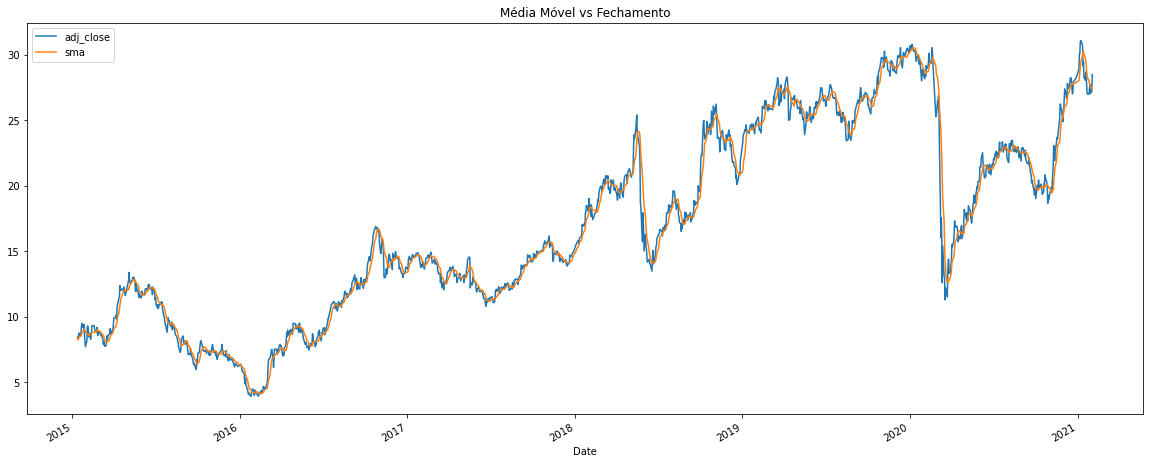

In [39]:
petr[['adj_close','sma']].dropna().plot(
    title='Média Móvel vs Fechamento',
    figsize=(20,8)
)

<AxesSubplot:title={'center':'Média Móvel vs Fechamento'}, xlabel='Date'>

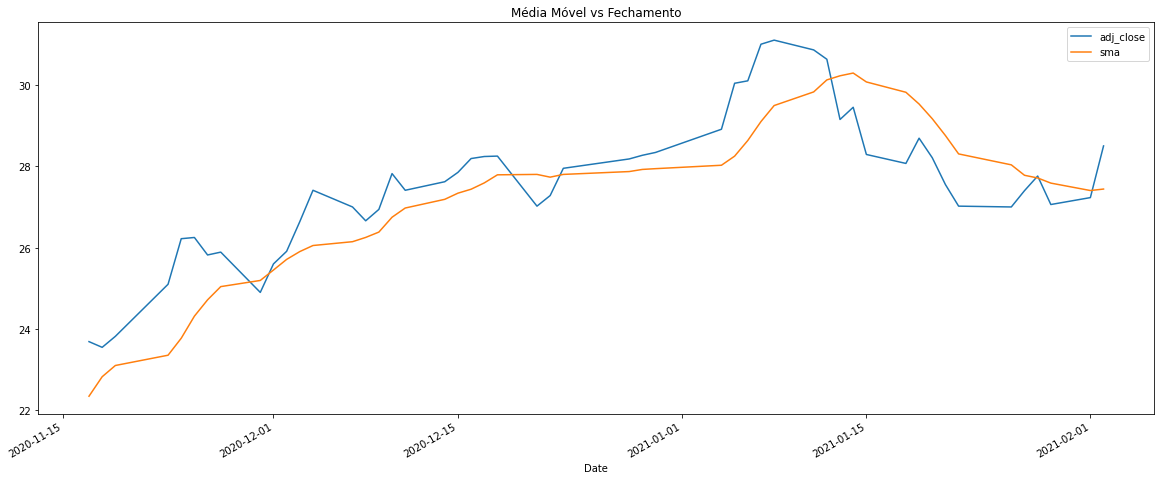

In [41]:
# Últimos 50 pregões
petr[['adj_close','sma']][-50:].dropna().plot(
    title='Média Móvel vs Fechamento',
    figsize=(20,8)
)

---
## Bollinger Bands

In [47]:
from talib import MA_Type

# upper, middle, lower = talib.BBANDS(petr.adj_close, matype=MA_Type.T3)
upper, middle, lower = (a.dropna() for a in talib.BBANDS(petr.adj_close, matype=MA_Type.T3)) # remove os NaN no começo

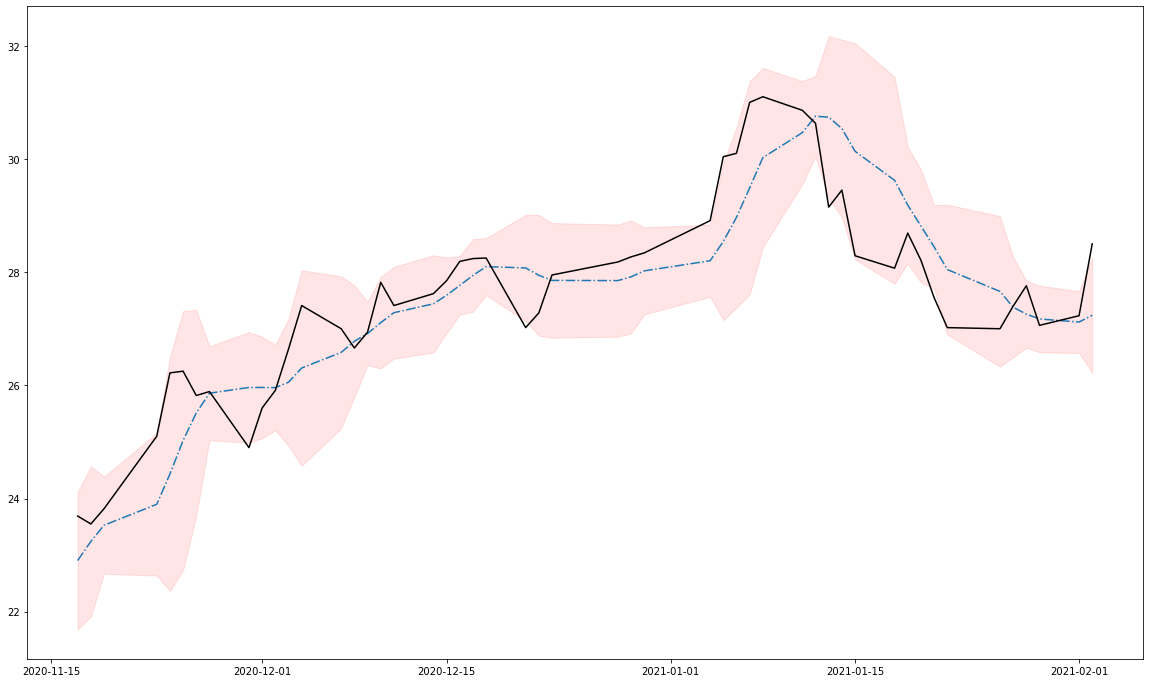

In [66]:
plt.figure(figsize=(20,12))
plt.plot(middle[-50:], "-.")
plt.plot(petr.adj_close[-50:], color="black")
plt.fill_between(
    middle[-50:].index, # eixo x
    upper[-50:], lower[-50:], # bandas em y
    alpha=.1,
    color="red"
)

Detecta o rompimento do preço para cima ou para baixo das bandas

In [122]:
detector = pd.concat([upper,lower,petr.adj_close], axis=1, join="inner")
detector.columns = ["up","lo","clo"]

In [149]:
detector['cruza'] = np.where(detector.clo > detector.up, 1, 0)
detector['cruza'] = np.where(detector.clo < detector.lo, -1, detector.cruza)

In [152]:
detector.cruza.value_counts()

 0    1332
-1      77
 1      76
Name: cruza, dtype: int64

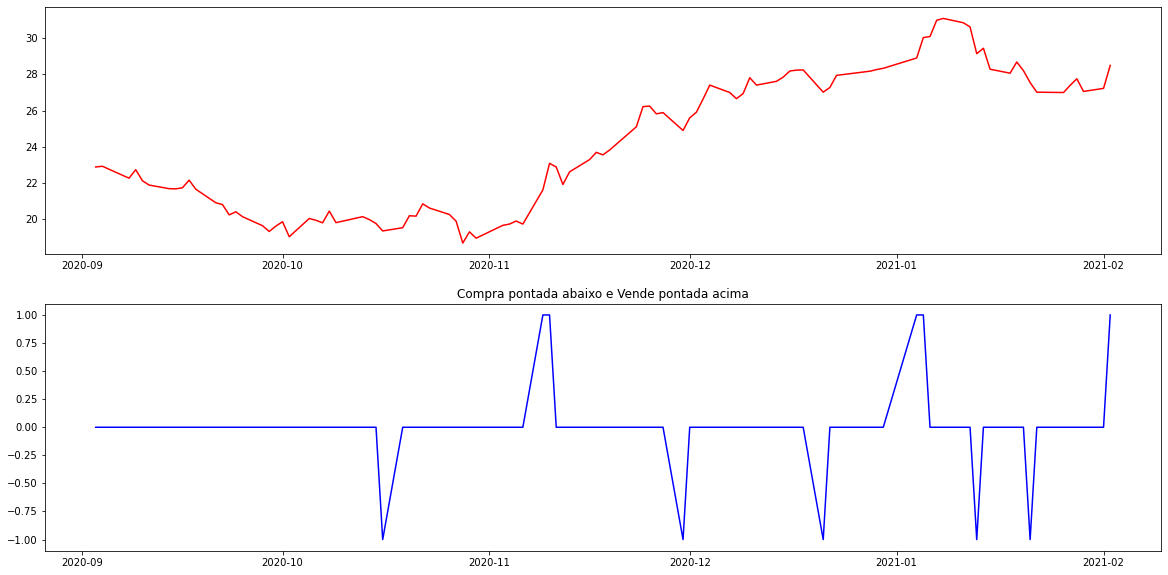

In [166]:
fig, ax = plt.subplots(2, 1, figsize=(20,10)) 
ax[0].plot(detector.clo[-100:], color="r")
ax[1].set_title('Compra pontada abaixo e Vende pontada acima')
ax[1].plot(detector.cruza[-100:], color='blue')
plt.show()

In [170]:
detector[detector.cruza!=0]

,up,lo,clo,cruza
Date,,,,
2015-03-10,8.999076,7.921281,7.904026,-1
2015-03-23,8.617271,7.938852,8.655464,1
2015-03-24,8.730405,8.103994,8.738957,1
2015-04-09,10.694616,9.354897,10.742794,1
2015-04-23,12.367454,12.125143,11.939530,-1
...,...,...,...,...
2021-01-04,28.838436,27.564702,28.910000,1
2021-01-05,29.931770,27.152946,30.040001,1
2021-01-13,32.170961,29.304615,29.150000,-1


## CDL3INSIDE - Three Inside Up/Down

In [81]:
def unpack(ativo):
    return (ativo.open, ativo.high, ativo.low, ativo.close)
open_, high, low, close = unpack(petr)

<AxesSubplot:xlabel='Date'>

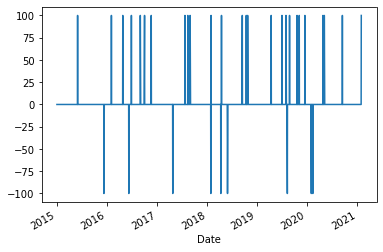

In [90]:
# CDL3INSIDE - Three Inside Up/Down
integer = talib.CDL3INSIDE(open_, high, low, close)
integer.plot()

In [89]:
integer.value_counts()

 0      1474
 100      26
-100       9
dtype: int64

---
## AROON

In [92]:
aroondown, aroonup = talib.AROON(high, low, timeperiod=14)

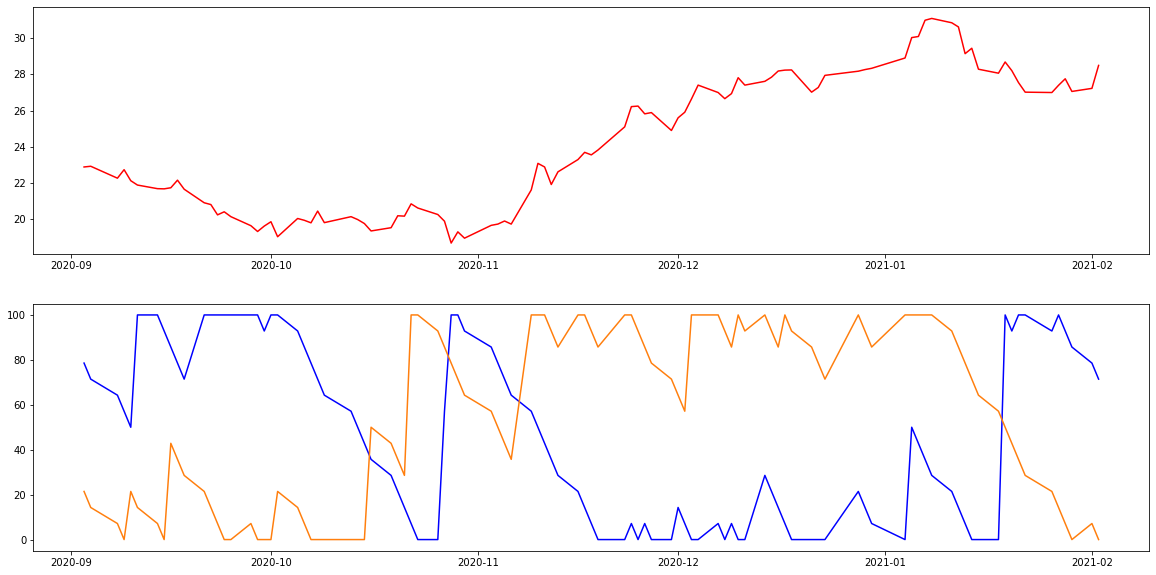

In [111]:
fig, ax = plt.subplots(2, 1, figsize=(20,10)) 
ax[0].plot(petr.adj_close[-100:], color="r")
ax[1].plot(aroondown[-100:], color='blue')
ax[1].plot(aroonup[-100:], color='tab:orange')